In [110]:
import os, sys, time
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import json
import numpy as np
from collections import defaultdict
from scipy import stats
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device, json2dict
from utils.vit_util import transforms, transforms_c100
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import torch
device = get_device()

ds_name = "c100"
k = 0
tgt_rank = 1
# pretrained modelのロード
pretrained_dir = getattr(ViTExperiment, ds_name).OUTPUT_DIR.format(k=k)
de_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "tgt_repair_weight_by_de")

Device: cuda


In [111]:
alphas = []
trackers = []
for i in range(1, 5):
    setting_path = f"/src/repair_weight_settings/setting_{i}.json"
    setting_dict = json2dict(setting_path)
    alpha = setting_dict["alpha"]
    alphas.append(alpha)
    tracking_path = os.path.join(de_dir, f"tracker_{i}.pkl")
    tracker = pickle.load(open(tracking_path, "rb"))
    trackers.append(tracker)

In [44]:
trackers[0].keys()

dict_keys(['fitness', 'fitness_for_correct', 'fitness_for_wrong', 'term1_pos', 'term2_pos', 'term1_neg', 'term2_neg'])

# 世代ごとのベストのfitnessの値を表示

In [72]:
def plot_tracker(key):
    colors = sns.color_palette("tab10", n_colors=4)
    plt.figure(figsize=(8, 6))
    for i in range(1, 5):
        alpha = alphas[i-1]
        tracker = trackers[i-1]
        color = colors[i-1]
        plt.plot(tracker[key], label=rf"$\alpha$={alpha}", color=color, alpha=0.7)
    plt.xlabel("generation")
    plt.ylabel(key)
    plt.title(f"{key} by generation")
    plt.legend()
    plt.show()

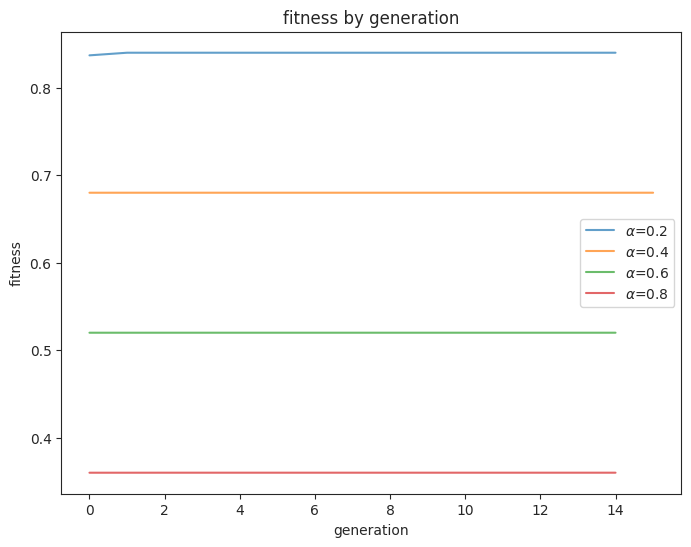

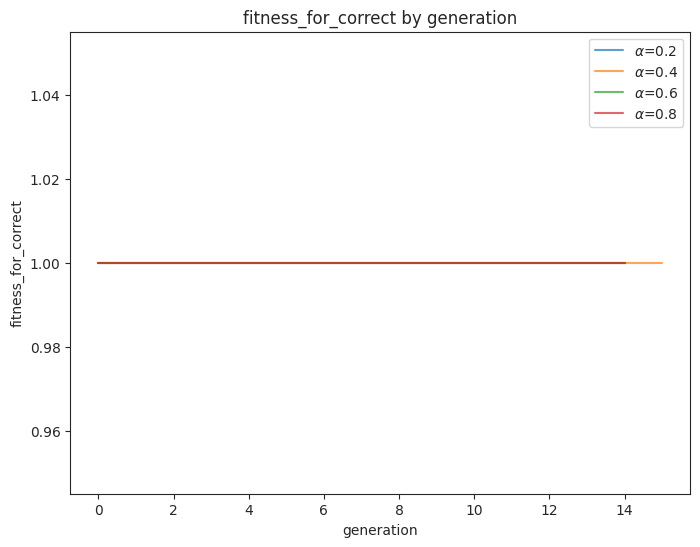

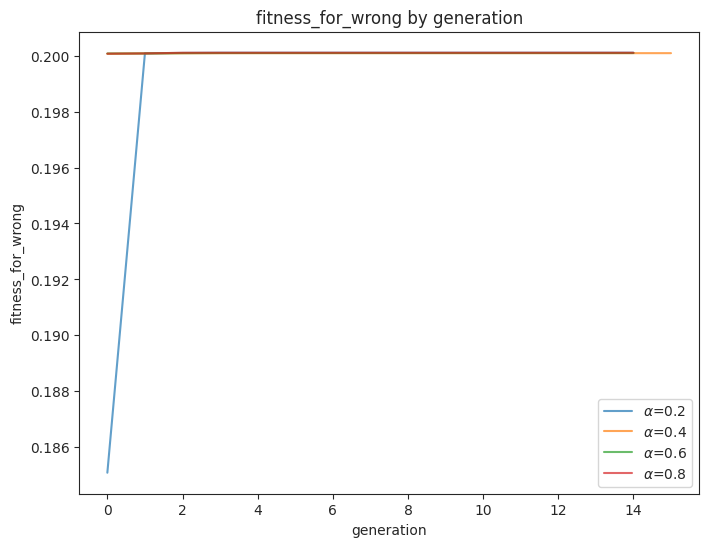

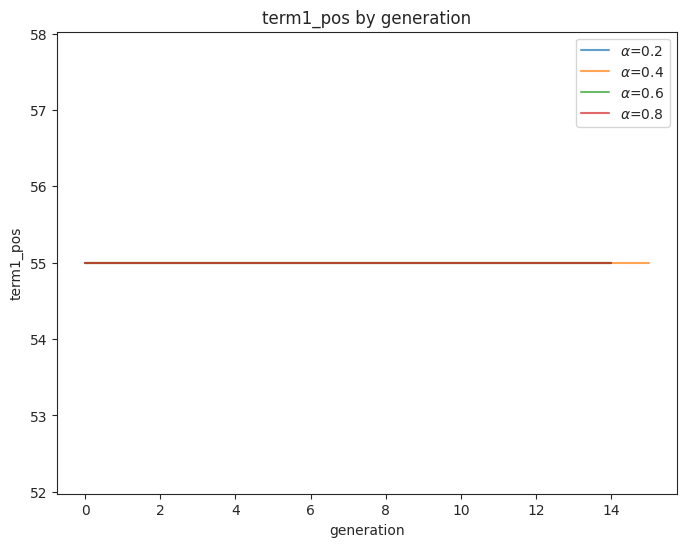

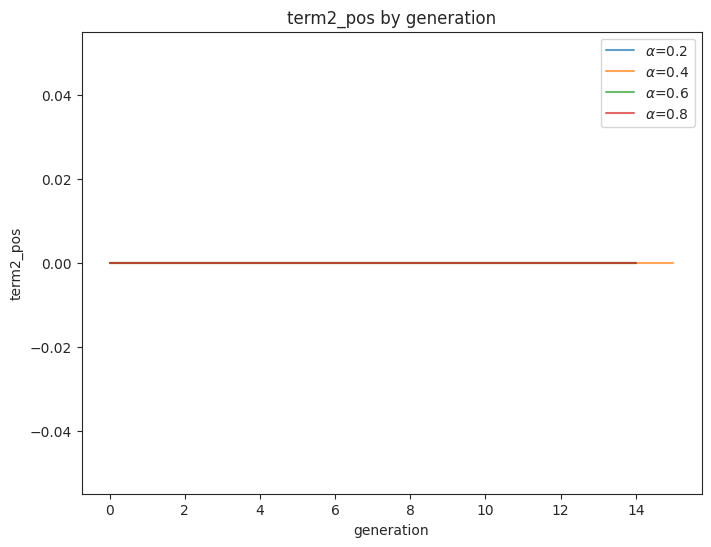

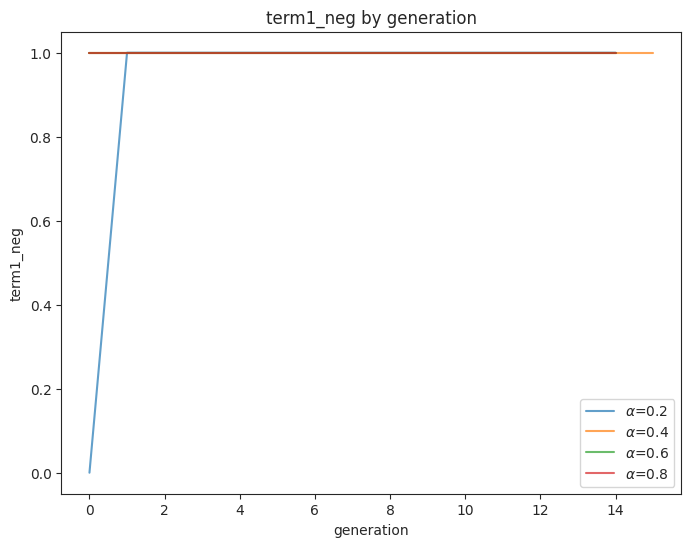

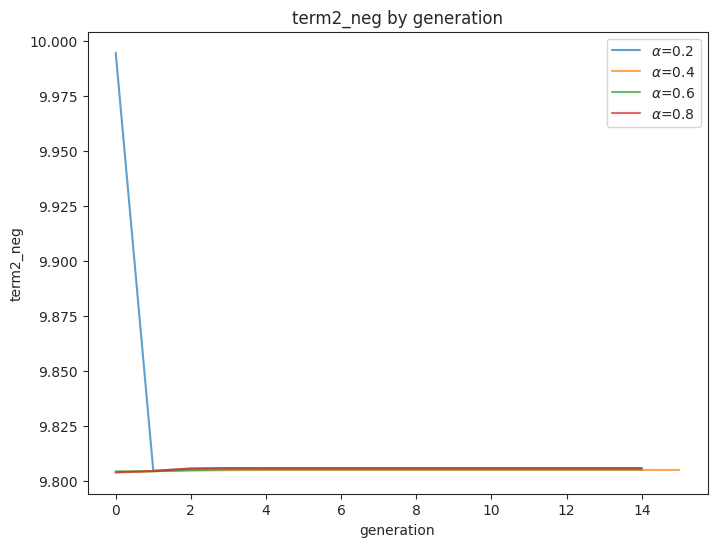

In [73]:
for key in trackers[0].keys():
    plot_tracker(key)

# FLのハイパラ $n$ と特定されるニューロンの割合
$n=768$ だと全ニューロン特定するので割合は 100% になる．

対象のニューロン数の母数は 768 \* 3072 + 768 \* 3072 = 4718592．
これに対して $n$ を指定することで， $8n^2$ のニューロンが特定されるので，百聞率での割合は，
$$
\frac{8n^2}{4718592} \times 100 (\%)
$$
となる．

n=5, ratio=0.004%
n=15, ratio=0.038%
n=25, ratio=0.106%
n=35, ratio=0.208%
n=45, ratio=0.343%
n=55, ratio=0.513%
n=65, ratio=0.716%
n=75, ratio=0.954%
n=85, ratio=1.225%
n=95, ratio=1.530%
n=105, ratio=1.869%
n=115, ratio=2.242%
n=125, ratio=2.649%
n=135, ratio=3.090%
n=145, ratio=3.565%
n=155, ratio=4.073%
n=165, ratio=4.616%
n=175, ratio=5.192%
n=185, ratio=5.803%
n=195, ratio=6.447%
n=205, ratio=7.125%
n=215, ratio=7.837%
n=225, ratio=8.583%
n=235, ratio=9.363%
n=245, ratio=10.177%
n=255, ratio=11.024%
n=265, ratio=11.906%
n=275, ratio=12.822%
n=285, ratio=13.771%
n=295, ratio=14.754%
n=305, ratio=15.772%
n=315, ratio=16.823%
n=325, ratio=17.908%
n=335, ratio=19.027%
n=345, ratio=20.180%
n=355, ratio=21.367%
n=365, ratio=22.587%
n=375, ratio=23.842%
n=385, ratio=25.130%
n=395, ratio=26.453%
n=405, ratio=27.809%
n=415, ratio=29.199%
n=425, ratio=30.624%
n=435, ratio=32.082%
n=445, ratio=33.574%
n=455, ratio=35.099%
n=465, ratio=36.659%
n=475, ratio=38.253%
n=485, ratio=39.881%
n=495,

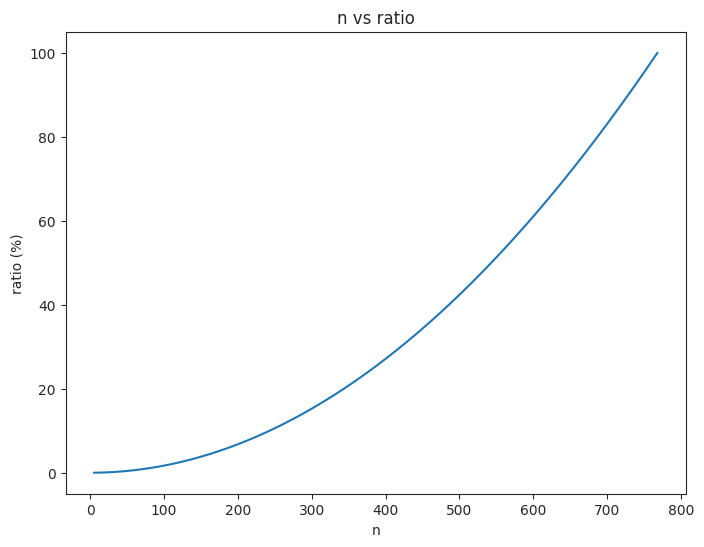

In [106]:
ratio = lambda n: 800 * n * n / 4718592
nlist, rlist = [], []
for n in range(5, 769):
    r = ratio(n)
    if r <= 100:
        nlist.append(n)
        rlist.append(r)
        if (n+5) % 10 == 0:
            print(f"n={n}, ratio={r:.3f}%")
plt.figure(figsize=(8, 6))
plt.plot(nlist, rlist)
plt.xlabel("n")
plt.ylabel("ratio (%)")
plt.title("n vs ratio")
plt.show()

# $\alpha$, $n$ の組み合わせごとに結果を描画

In [116]:
def get_nlist():
    # あるnが対象FFNの何%のニューロン数に対応するかを返す
    get_change_ratio = lambda n: 800 * n * n / 4718592
    nlist, rlist = [], []
    for n in range(5, 769):
        r = get_change_ratio(n)
        if r <= 100:
            nlist.append(n)
            rlist.append(r)
    # 1, 5, 10x% (x=1,..,9)に最も近くなるnを取得
    target_ratios = np.array([1, 5, 10])
    tgt_nlist = []
    for target in target_ratios:
        closest_n = min(zip(nlist, rlist), key=lambda x: abs(x[1] - target)) # keyはminの計算の際の大きい小さいの基準
        tgt_nlist.append(closest_n[0])
    return tgt_nlist

trackers = {}
alpha_list = [0.2, 0.4, 0.6, 0.8]
n_list = get_nlist()
from itertools import product
for n, alpha in product(n_list, alpha_list):
    tracking_path = os.path.join(de_dir, f"tracker_n{n}_alpha{alpha}.pkl")
    tracker = pickle.load(open(tracking_path, "rb"))
    trackers[(n, alpha)] = tracker

In [124]:
def plot_tracker(key):
    for n in n_list:
        plt.figure(figsize=(8, 6))
        for alpha in alpha_list:
            tracker = trackers[(n, alpha)]
            plt.plot(tracker[key], label=rf"$\alpha$={alpha}", alpha=0.5)
        plt.xlabel("generation")
        plt.ylabel(key)
        plt.title(f"{key} by generation (n={n})")
        plt.legend()
        plt.show()

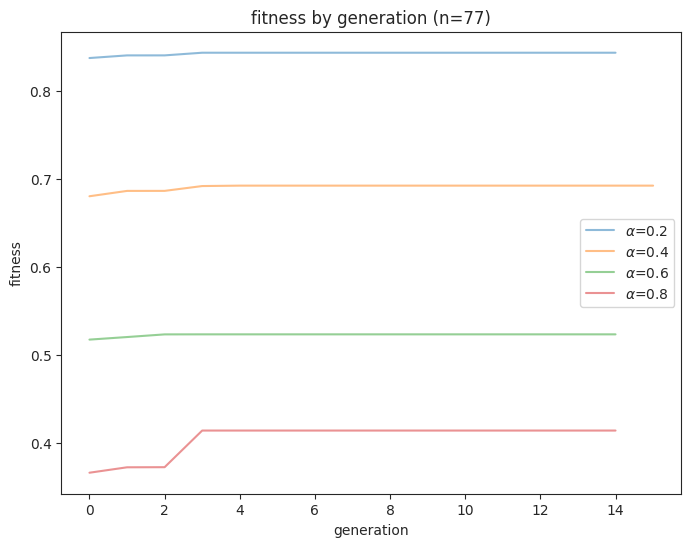

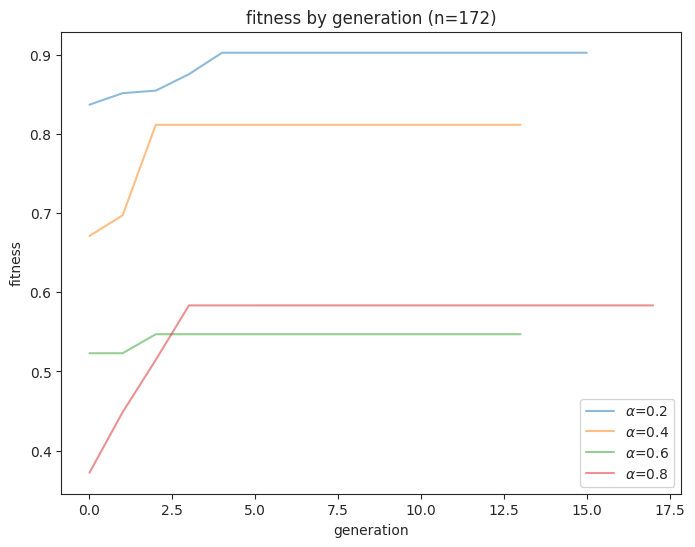

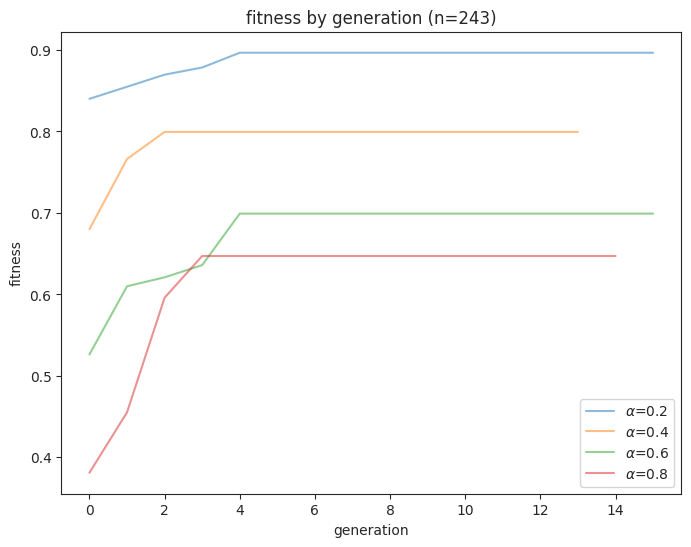

In [125]:
plot_tracker("fitness")

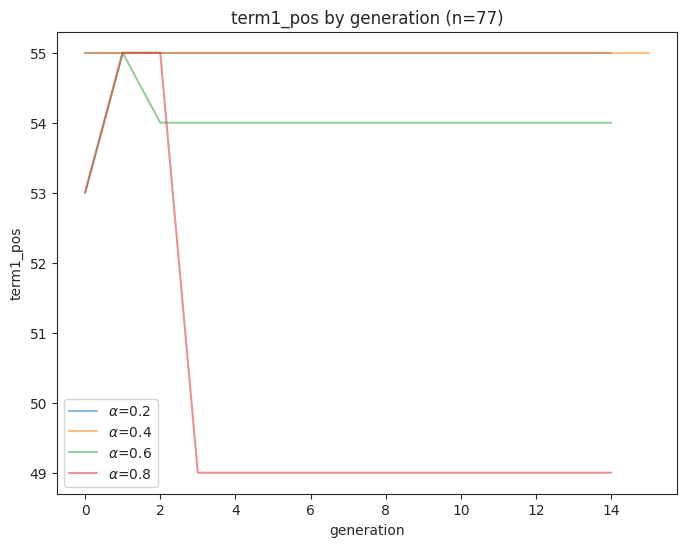

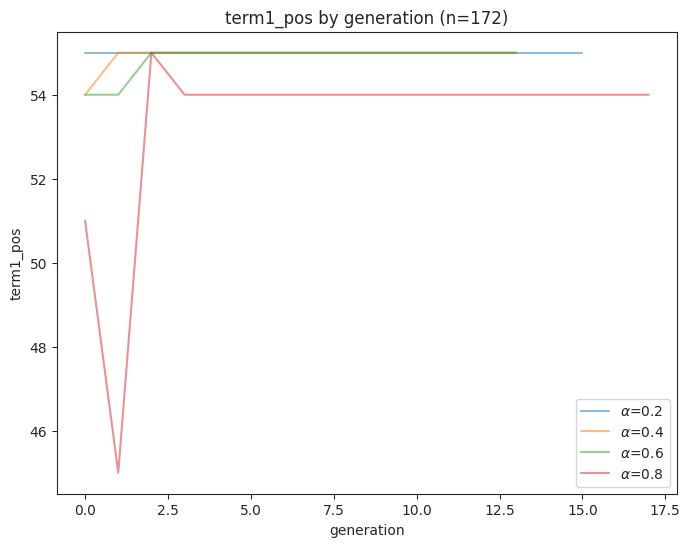

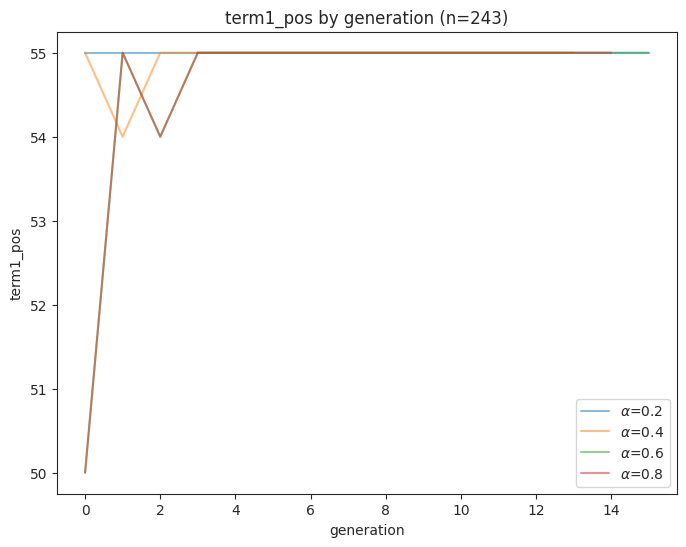

In [126]:
plot_tracker("term1_pos")

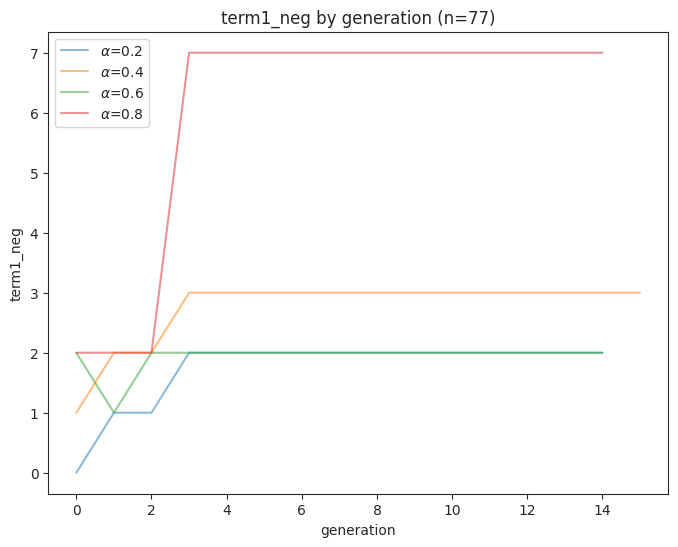

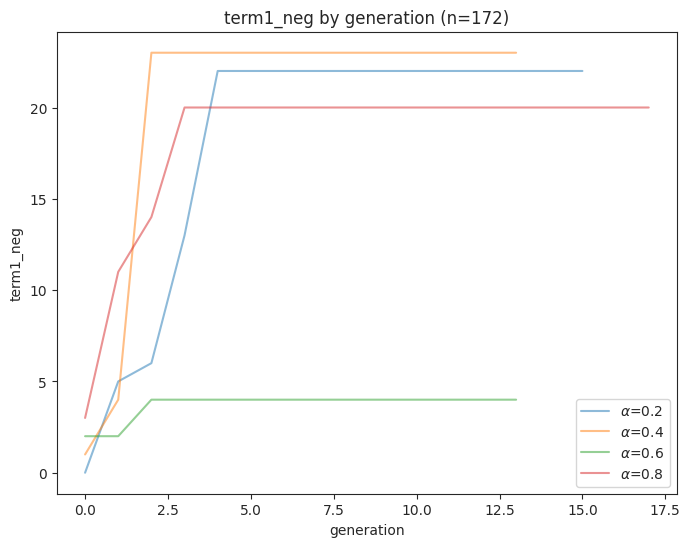

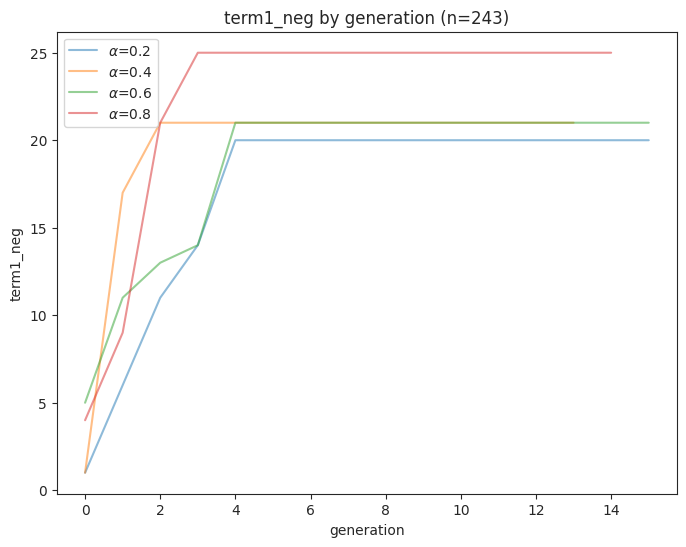

In [127]:
plot_tracker("term1_neg")